In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import norm
from scipy import stats
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

## Task 1. A/B-testing analysis

In [2]:
#Read the file with information about group membership. Change column names when reading.
df_users = pd.read_csv('/Users/Nast/Documents/Karpov.Courses/Final_project/test1/Проект_2_groups.csv', sep = ';',  header=0, names = ['student_id', 'group'])

In [3]:
df_users

,student_id,group
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [4]:
#Review the data
df_users.nunique()

student_id    74484
group             2
dtype: int64

In [5]:
df_users.group.value_counts()

B    59813
A    14671
Name: group, dtype: int64

In [6]:
df_users.dtypes

student_id     int64
group         object
dtype: object

In [7]:
#Read the file with user data updates
df_users_add = pd.read_csv('/Users/Nast/Documents/Karpov.Courses/Final_project/test1/Проект_2_group_add.csv', sep = ',', header=0, names = ['student_id', 'group'])

In [8]:
df_users_add

,student_id,group
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [9]:
#Review the data
df_users_add.nunique()

student_id    92
group          2
dtype: int64

In [11]:
df_users_add.group.value_counts()

B    70
A    22
Name: group, dtype: int64

In [12]:
df_users_add.dtypes

student_id     int64
group         object
dtype: object

In [13]:
#Add new data to the list of users
df_users_upd = df_users.append(df_users_add)

In [14]:
df_users_upd

,student_id,group
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [15]:
#Review the data
df_users_upd.nunique()

student_id    74576
group             2
dtype: int64

In [16]:
#Read the file with data on website visits 
df_active = pd.read_csv('/Users/Nast/Documents/Karpov.Courses/Final_project/test1/Проект_2_active_studs.csv')

In [17]:
df_active

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [18]:
#Review the data
df_active.student_id.nunique()

8341

In [19]:
df_active.student_id.isna().sum()

0

In [20]:
df_active.dtypes

student_id    int64
dtype: object

In [21]:
#Read the file with info on purchases
df_checks =  pd.read_csv('/Users/Nast/Documents/Karpov.Courses/Final_project/test1/Проект_2_checks.csv', sep = ';')

In [22]:
df_checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [23]:
#Review the data
df_checks.dtypes

student_id      int64
rev           float64
dtype: object

In [24]:
df_checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [25]:
df_checks.student_id.nunique()

541

In [26]:
#Merge the two dfs so that only users, who logged in to the platform, remain. 
#If a user has made a purshase but has not logged in to the platform, we cannot evaluate the impact of the new mechanics.
df_act_checks = df_active.merge(df_checks, how = 'left', on = 'student_id')

In [27]:
df_act_checks

,student_id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN
...,...,...
8336,1794344,NaN
8337,296883,NaN
8338,3598448,NaN
8339,3610547,290.0


In [28]:
#Review the data
df_act_checks.isna().sum()

student_id       0
rev           7949
dtype: int64

In [29]:
df_act_checks.student_id.nunique()

8341

In [30]:
#Let's add information about which test group the users belong to. Let's leave only those who logged in to the platform.
df_test = df_act_checks.merge(df_users_upd, how = 'left', on = 'student_id')

In [31]:
df_test

,student_id,rev,group
0,581585,NaN,A
1,5723133,NaN,A
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B
...,...,...,...
8336,1794344,NaN,B
8337,296883,NaN,B
8338,3598448,NaN,B
8339,3610547,290.0,B


In [32]:
df_test.isna().sum()

student_id       0
rev           7949
group            0
dtype: int64

In [33]:
df_test.group.value_counts()
#The groups vary in size, but in our case it is acceptable, as there are enough users in each group

B    6803
A    1538
Name: group, dtype: int64

Let's assume that the experiment lasted 7 days, the groups are from the same general population, are representative, and any additional factors, that may affect the result, are removed.
We have data:

-what users visited the website (number of visits is not known)

-how much each user paid for the period of the experiment (the number of payments is not known).

Hence, the metrics we can look at are:

-Average revenue per user

-conversion to purchase

### Let's look at the average revenue for each group

In [34]:
df_test.groupby('group', as_index = False).agg({'rev': 'mean'}).rename(columns={'rev': 'avg_rev'})

,group,avg_rev
0,A,933.589744
1,B,1257.878992


We see that the average revenue per user in the test group is significantly higher than in the control group. Let's check the statistical significance of these differences.

In [35]:
#Let's look at the stats in the test group
df_test.loc[df_test['group'] == 'B'].rev.describe()

count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

<AxesSubplot:>

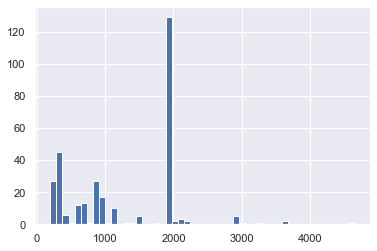

In [36]:
#Let's look at the distribution of the data in the test group
df_test.loc[df_test['group'] == 'B'].rev.hist(bins=50)

In [37]:
#And now the stats in the control group
df_test.loc[df_test['group'] == 'A'].rev.describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

<AxesSubplot:>

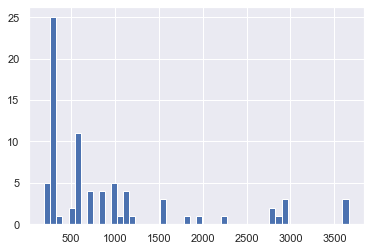

In [38]:
#And the distribution in the control group...
df_test.loc[df_test['group'] == 'A'].rev.hist(bins=50)

Given that in both groups the distribution is far from normal, and in addition, the groups differ greatly in the number of observations, we will use the bootstrap method to test the null hypothesis of equality of the means.

#### Let's declare a function that will allow us to test hypotheses using bootstrap

In [39]:
def get_bootstrap(
    data_column_1, #numerical values of the first sample
    data_column_2, #numerical values of the second sample
    boot_it = 1000, #number of bootstrap subsamples
    statistic = np.mean, #statistics of interest (mean)
    bootstrap_conf_level = 0.95 #significance level
):
    boot_data = []
    for i in tqdm(range(boot_it)): #pull subsamples
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True #return parameter
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) #apply the statistic
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [40]:
#For bootstrap, we replace missing values with zeros
df_test_values = df_test.copy(deep=True)
df_test_values.rev = df_test_values.rev.fillna(0)

In [41]:
b = df_test_values[df_test_values['group'] == 'B']['rev']
a = df_test_values[df_test_values['group'] == 'A']['rev']

In [42]:
booted_data = get_bootstrap(b, a) #difference of two distributions, confidence interval and p-value

  0%|          | 0/1000 [00:00<?, ?it/s]

In [43]:
#Getting p-value
booted_data["p_value"]

0.03445713290676521

In [44]:
#Getting confidence interval
booted_data["quants"]

,0
0.025,1.030502
0.975,20.527161


#### Zero does not fall within CI, and p_value < 0.05, which allows us to reject the null hypothesis of equality of the means. That is, there are significant differences between the test and control groups

### Let's take a look at the conversion to purchase

In [45]:
#Create a df
cr = df_test.groupby('group', as_index = False) \
            .agg({'rev': 'count', 'student_id': 'count'}) \
            .rename(columns = {'rev': 'payment_count', 'student_id': 'actives_count'})

In [46]:
cr['cr'] = cr.payment_count / cr.actives_count * 100

In [47]:
cr

,group,payment_count,actives_count,cr
0,A,78,1538,5.071521
1,B,314,6803,4.615611


We can see that the conversion rate is higher in the control group than in the test group. Let's check the data using chi-square, since the data are categorical (bought/not bought)

In [48]:
cr['no_purchase'] = cr.actives_count - cr.payment_count

In [49]:
cr

,group,payment_count,actives_count,cr,no_purchase
0,A,78,1538,5.071521,1460
1,B,314,6803,4.615611,6489


In [50]:
#Create a contingency table
table = pd.DataFrame()
table.insert(0, "Purchase", cr.payment_count)
table.insert(1, "No_purchase", cr.no_purchase)

In [51]:
table

,Purchase,No_purchase
0,78,1460
1,314,6489


In [52]:
p_value = stats.chi2_contingency(table)[1]
p_value

0.48625240457231045

#### Null hypothesis: the fact of purchase does not depend on the test group. Since the obtained p_value > 0.05, we cannot reject the null hypothesis.

### Conclusion:

#### The test data does not allow us to conclude that the new mechanics have a significant effect on conversion to purchase. However, we can see that the new mechanics has a positive effect on the growth of average revenue per user.

#### If the goal of changes in payment mechanics was to increase revenue per user, we can roll out the changes to all users.

#### If the goal was to increase conversion to purchase, then the mechanics should be finalized and tested again.

## Task 2. SQL

#### 2.1 Very hard working students.

#### 2.2 Funnel optimisation

## Task 3. Python

#### 1. Implement a function that will automatically load information from an additional groups_add.csv file (headers may vary) and recalculate metrics based on the additional parameters.

In [ ]:
#Read the file with information about group membership. Change column names when reading.
df_users = pd.read_csv('/Users/Nast/Documents/Karpov.Courses/Final_project/test1/Проект_2_groups.csv', sep = ';',  header=0, names = ['student_id', 'group'])

In [ ]:
#Read the file with data on website visits
df_active = pd.read_csv('/Users/Nast/Documents/Karpov.Courses/Final_project/test1/Проект_2_active_studs.csv')

In [ ]:
#Read the file with purchases
df_checks =  pd.read_csv('/Users/Nast/Documents/Karpov.Courses/Final_project/test1/Проект_2_checks.csv', sep = ';')

In [ ]:
#Merge the two dfs so that only those users who logged into the platform remain. 
#If a user has made a payment but hasn't logged into the platform, we can't assess the impact of the new mechanics on them.
df_act_checks = df_active.merge(df_checks, how = 'left', on = 'student_id')

In [ ]:
path = '/Users/Nast/Documents/Karpov.Courses/Final_project/test1/Проект_2_group_add.csv' #Specify the path to the file with the update

today_date = datetime.today().strftime('%Y-%m-%d') #Define the update date

def data_upd(df_to_upd):
    df_users_add = pd.read_csv(path, sep = ',', header=0, names = ['student_id', 'group']) #Read the additional file, write the column names we need
    df_to_upd = df_to_upd.append(df_users_add) #Add new data to the list of users
    df_test = df_act_checks.merge(df_to_upd, how = 'left', on = 'student_id') #Let's add information about which test group the users belong to. Let's leave only those who logged in to the platform.
    avg_revenue = df_test.groupby('group', as_index = False).agg({'rev': 'mean'}).rename(columns={'rev': 'avg_rev'}) #Average income in groups
    
    cr_table = df_test.groupby('group', as_index = False) \
            .agg({'rev': 'count', 'student_id': 'count'}) \
            .rename(columns = {'rev': 'payment_count', 'student_id': 'actives_count'}) #Calculate conversion
    cr_table['cr'] = cr_table.payment_count / cr_table.actives_count * 100 #Convert to percentage
    cr = cr_table[['group', 'cr']] #Leave only the necessary columns in the table
    
    final_results = avg_revenue.merge(cr, how = 'inner', on = 'group') #Combine the metrics into a common table
    final_results['date'] = today_date #Update the date
    
    return(final_results)

In [ ]:
df_to_vis = data_upd(df_users) #assign a name to be used in the next task
df_to_vis

#### 2. Implement a function that will plot the resulting metrics.

In [ ]:
def data_visual(df_to_vis):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5)) #to fit two different graphs side by side

    sns.barplot(ax=axes[0], x=df_to_vis.date, y=df_to_vis.avg_rev, hue=df_to_vis.group)
    axes[0].set_title('Average Revenue per user')

    sns.barplot(ax=axes[1], x=df_to_vis.date, y=df_to_vis.cr, hue=df_to_vis.group)
    axes[1].set_title('Convertion Rate')
    
    return

In [ ]:
data_visual(df_to_vis)